In [1]:
import os
import parse
import pickle
import copy
import math
import argparse

import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import dionysus as dion
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn import manifold
from collections import OrderedDict
import sklearn
import networkx as nx
import seaborn as sns

from pt_activation.models.fff import FFF as FFFRelu
from pt_activation.models.linear import FFF
from pt_activation.models.simple_mnist import CFF as CFFRelu
from pt_activation.models.simple_mnist_sigmoid import CFF as CFFSigmoid
from pt_activation.models.ccff import CCFF as CCFFRelu

%load_ext autoreload
%autoreload 2

In [2]:
model_location = '/home/tgebhart/projects/pt_activation/logdir/models/fashion/cff_sigmoid.pt'
adv_directory_loc = '/home/tgebhart/projects/pt_activation/logdir/adversaries/fashion/gaussian_noise/cff_sigmoid.pt'
save_loc = '/home/tgebhart/projects/pt_activation/logdir/distance/CFFSigmoid/gaussian_noise'
test_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST('../../data/fashion', train=False, download=True, transform=transforms.Compose([
                           transforms.ToTensor(),
                       ])), batch_size=1, shuffle=False, **{'num_workers': 1, 'pin_memory': True})

model = CFFSigmoid()
model.load_state_dict(torch.load(model_location))

In [3]:
def get_adv_info(filename):
    format_string = 'true-{}_adv-{}_sample-{}.npy'
    parsed = parse.parse(format_string, filename)
    return {'true class':int(parsed[0]), 'adv class':int(parsed[1]), 'sample':int(parsed[2])}

def read_adversaries(loc):
    ret = []
    for f in os.listdir(loc):
        if os.path.isfile(os.path.join(loc,f)) and f.find('.npy') != -1:
            adv = np.load(os.path.join(loc, f))
            info = get_adv_info(f)
            info['adversary'] = adv
            ret.append(info)
    return ret


def create_diagram(f):
    m = dion.homology_persistence(f)
    dgms = dion.init_diagrams(m,f)
    return dgms[0]


def create_lifetimes(dgms):
    return [[pt.birth - pt.death for pt in dgm if pt.death < np.inf] for dgm in dgms]

def get_example_images(test_loader):
    ret = {}
    for data, target in test_loader:
        if target.numpy()[0] not in ret:
            ret[target.numpy()[0]] = data.numpy()
    return ret

def create_diagrams(model, batch_size, up_to, test_loader):
    device = torch.device("cpu")
    
    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    images = []
    diagrams = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss = F.nll_loss(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for s in range(data.shape[0]):
                this_hiddens = [hiddens[i][s] for i in range(len(hiddens))]
                print('Filtration: {}'.format(s+t))
                f = model.compute_dynamic_filtration(data[s], this_hiddens)
                dg = create_diagram(f)
                diagrams.append(dg)
                images.append(data.cpu().numpy()[s])
                row = {'loss':test_loss, 'class':int(target.cpu().numpy()[s]), 'prediction':int(pred.cpu().numpy()[s][0])}
                res_df.append(row)


            t += batch_size
            if t >= up_to:
                break

    return pd.DataFrame(res_df), images, diagrams


def create_adversary_diagrams(model, batch_size, up_to, adversaries):
    device = torch.device("cpu")
    
    adv_images = torch.tensor(np.array([a['adversary'] for a in adversaries]))
    adv_labels = torch.tensor(np.array([a['true class'] for a in adversaries]))
    adv_samples = [a['sample'] for a in adversaries]

    print(adv_images.shape, adv_labels.shape)

    advs = torch.utils.data.TensorDataset(adv_images, adv_labels)
    test_loader = torch.utils.data.DataLoader(advs, batch_size=batch_size, shuffle=False)

    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    diagrams = []
    with torch.no_grad():

        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss = F.nll_loss(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for s in range(data.shape[0]):
                this_hiddens = [hiddens[i][s] for i in range(len(hiddens))]
                print('Filtration: {}'.format(s+t))
                f = model.compute_dynamic_filtration(data[s], this_hiddens)
                dg = create_diagram(f)
                diagrams.append(dg)
                row = {'loss':test_loss, 'class':int(target.cpu().numpy()[s]), 'prediction':int(pred.cpu().numpy()[s][0]), 'sample':int(adv_samples[t])}
                res_df.append(row)


            t += (batch_size)
            if t >= up_to:
                break

    return pd.DataFrame(res_df), diagrams

In [4]:
adversaries = read_adversaries(adv_directory_loc)
adversaries = sorted(adversaries,  key=lambda k: k['sample'])

In [5]:
res_df, images, diags = create_diagrams(model, 1, 500, test_loader)
adv_df, adv_diags = create_adversary_diagrams(model, 1, 500, adversaries)

Filtration: 0
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 108710
Sorting filtration...
Filtration: 1
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 139145
Sorting filtration...
Filtration: 2
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 105685
Sorting filtration...
Filtration: 3
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 104619
Sorting filtration...
Filtration: 4
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 142920
Sorting filtration...
Filtration: 5
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 110634
Sorting filtration...
Filtration: 6
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 131230
Sorting filtration...
Filtration: 7
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 139523
Sorting filtration...
Filtration: 8
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 84750
Sorting filtration...
Filtration: 9
h1_id_

filtration size 135999
Sorting filtration...
Filtration: 75
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 112987
Sorting filtration...
Filtration: 76
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 109545
Sorting filtration...
Filtration: 77
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 141133
Sorting filtration...
Filtration: 78
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 145703
Sorting filtration...
Filtration: 79
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 142665
Sorting filtration...
Filtration: 80
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 106280
Sorting filtration...
Filtration: 81
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 144102
Sorting filtration...
Filtration: 82
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 109373
Sorting filtration...
Filtration: 83
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration

h2_id_start 2107
h3_id_start 2157
filtration size 139947
Sorting filtration...
Filtration: 150
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 136481
Sorting filtration...
Filtration: 151
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 146345
Sorting filtration...
Filtration: 152
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 110343
Sorting filtration...
Filtration: 153
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 133834
Sorting filtration...
Filtration: 154
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 86564
Sorting filtration...
Filtration: 155
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 146936
Sorting filtration...
Filtration: 156
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 132253
Sorting filtration...
Filtration: 157
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 98544
Sorting filtration...
Filtration: 158
h1_id_start 784
h2_

h2_id_start 2107
h3_id_start 2157
filtration size 130838
Sorting filtration...
Filtration: 224
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 108474
Sorting filtration...
Filtration: 225
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 103134
Sorting filtration...
Filtration: 226
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 128084
Sorting filtration...
Filtration: 227
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 137978
Sorting filtration...
Filtration: 228
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 102605
Sorting filtration...
Filtration: 229
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 137466
Sorting filtration...
Filtration: 230
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 105530
Sorting filtration...
Filtration: 231
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 131064
Sorting filtration...
Filtration: 232
h1_id_start 784
h

h2_id_start 2107
h3_id_start 2157
filtration size 129930
Sorting filtration...
Filtration: 298
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 135228
Sorting filtration...
Filtration: 299
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 109299
Sorting filtration...
Filtration: 300
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 103182
Sorting filtration...
Filtration: 301
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 122748
Sorting filtration...
Filtration: 302
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 139864
Sorting filtration...
Filtration: 303
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 144041
Sorting filtration...
Filtration: 304
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 136987
Sorting filtration...
Filtration: 305
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 136755
Sorting filtration...
Filtration: 306
h1_id_start 784
h

h2_id_start 2107
h3_id_start 2157
filtration size 100385
Sorting filtration...
Filtration: 372
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 114394
Sorting filtration...
Filtration: 373
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 134799
Sorting filtration...
Filtration: 374
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 136478
Sorting filtration...
Filtration: 375
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 118748
Sorting filtration...
Filtration: 376
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 112546
Sorting filtration...
Filtration: 377
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 124575
Sorting filtration...
Filtration: 378
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 120372
Sorting filtration...
Filtration: 379
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 137090
Sorting filtration...
Filtration: 380
h1_id_start 784
h

h2_id_start 2107
h3_id_start 2157
filtration size 120718
Sorting filtration...
Filtration: 446
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 122056
Sorting filtration...
Filtration: 447
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 107927
Sorting filtration...
Filtration: 448
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 110577
Sorting filtration...
Filtration: 449
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 99794
Sorting filtration...
Filtration: 450
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 114721
Sorting filtration...
Filtration: 451
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 110530
Sorting filtration...
Filtration: 452
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 138051
Sorting filtration...
Filtration: 453
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 103917
Sorting filtration...
Filtration: 454
h1_id_start 784
h2

h2_id_start 2107
h3_id_start 2157
filtration size 133851
Sorting filtration...
Filtration: 20
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 150138
Sorting filtration...
Filtration: 21
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 105623
Sorting filtration...
Filtration: 22
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 127132
Sorting filtration...
Filtration: 23
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 106499
Sorting filtration...
Filtration: 24
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 122783
Sorting filtration...
Filtration: 25
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 142524
Sorting filtration...
Filtration: 26
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 145336
Sorting filtration...
Filtration: 27
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 129700
Sorting filtration...
Filtration: 28
h1_id_start 784
h2_id_star

h2_id_start 2107
h3_id_start 2157
filtration size 125656
Sorting filtration...
Filtration: 95
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 124345
Sorting filtration...
Filtration: 96
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 128116
Sorting filtration...
Filtration: 97
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 126012
Sorting filtration...
Filtration: 98
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 144588
Sorting filtration...
Filtration: 99
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 143637
Sorting filtration...
Filtration: 100
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 124891
Sorting filtration...
Filtration: 101
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 145291
Sorting filtration...
Filtration: 102
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 123843
Sorting filtration...
Filtration: 103
h1_id_start 784
h2_id_

h2_id_start 2107
h3_id_start 2157
filtration size 138812
Sorting filtration...
Filtration: 169
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 149464
Sorting filtration...
Filtration: 170
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 134399
Sorting filtration...
Filtration: 171
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 117238
Sorting filtration...
Filtration: 172
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 144096
Sorting filtration...
Filtration: 173
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 120520
Sorting filtration...
Filtration: 174
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 139804
Sorting filtration...
Filtration: 175
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 127817
Sorting filtration...
Filtration: 176
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 137171
Sorting filtration...
Filtration: 177
h1_id_start 784
h

h2_id_start 2107
h3_id_start 2157
filtration size 133586
Sorting filtration...
Filtration: 243
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 135135
Sorting filtration...
Filtration: 244
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 134013
Sorting filtration...
Filtration: 245
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 129904
Sorting filtration...
Filtration: 246
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 130646
Sorting filtration...
Filtration: 247
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 143631
Sorting filtration...
Filtration: 248
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 142574
Sorting filtration...
Filtration: 249
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 137993
Sorting filtration...
Filtration: 250
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 131397
Sorting filtration...
Filtration: 251
h1_id_start 784
h

h2_id_start 2107
h3_id_start 2157
filtration size 122286
Sorting filtration...
Filtration: 317
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 127272
Sorting filtration...
Filtration: 318
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 135201
Sorting filtration...
Filtration: 319
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 145625
Sorting filtration...
Filtration: 320
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 136843
Sorting filtration...
Filtration: 321
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 131387
Sorting filtration...
Filtration: 322
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 144153
Sorting filtration...
Filtration: 323
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 116986
Sorting filtration...
Filtration: 324
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 137164
Sorting filtration...
Filtration: 325
h1_id_start 784
h

h2_id_start 2107
h3_id_start 2157
filtration size 136376
Sorting filtration...
Filtration: 391
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 139090
Sorting filtration...
Filtration: 392
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 130393
Sorting filtration...
Filtration: 393
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 116981
Sorting filtration...
Filtration: 394
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 141638
Sorting filtration...
Filtration: 395
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 125484
Sorting filtration...
Filtration: 396
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 138822
Sorting filtration...
Filtration: 397
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 129570
Sorting filtration...
Filtration: 398
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 123689
Sorting filtration...
Filtration: 399
h1_id_start 784
h

h2_id_start 2107
h3_id_start 2157
filtration size 133617
Sorting filtration...
Filtration: 465
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 135231
Sorting filtration...
Filtration: 466
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 122556
Sorting filtration...
Filtration: 467
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 132452
Sorting filtration...
Filtration: 468
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 136057
Sorting filtration...
Filtration: 469
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 121010
Sorting filtration...
Filtration: 470
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 131988
Sorting filtration...
Filtration: 471
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 143756
Sorting filtration...
Filtration: 472
h1_id_start 784
h2_id_start 2107
h3_id_start 2157
filtration size 124944
Sorting filtration...
Filtration: 473
h1_id_start 784
h

In [6]:
adv_df.head(10)

,class,loss,prediction,sample
0,9,1.728786,5,0
1,2,1.128822,6,1
2,1,1.560248,0,2
3,1,2.779277,2,3
4,6,1.440325,2,4
5,1,1.630780,4,5
6,4,1.194070,6,6
7,6,1.073864,2,7
8,5,2.511947,8,8
9,7,2.936471,5,9


In [7]:
distances = []
for i in range(adv_df.shape[0]):
    adv_dgm = adv_diags[i]
    img = images[int(adv_df.iloc[i]['sample'])][0]
    adv_img = adversaries[i]['adversary'][0]
    comp_choices = res_df[res_df['prediction'] == adv_df.iloc[i]['prediction']].index.tolist()
    comp_choice = np.random.choice(comp_choices)
    comp_img = images[int(comp_choice)][0]
    dgm = diags[int(adv_df.iloc[i]['sample'])]
    comp_dgm = diags[int(comp_choice)]
    dists = {}
    dists['wass_within_class'] = dion.wasserstein_distance(dgm, comp_dgm, q=2)
    dists['wass_to_adversary'] = dion.wasserstein_distance(dgm, adv_dgm, q=2)
    dists['inf_within_class'] = np.linalg.norm(img - comp_img, np.inf)
    dists['inf_to_adversary'] = np.linalg.norm(img - adv_img, np.inf)
    distances.append(dists)

In [8]:
dists_df = pd.DataFrame(distances)
dists_df.head(10)

,inf_to_adversary,inf_within_class,wass_to_adversary,wass_within_class
0,4.187354,17.600000,0.801981,0.787879
1,32.222710,12.137255,6.795333,2.153544
2,19.817081,13.937254,5.549258,1.826564
3,18.197426,12.215686,4.649427,2.015603
4,13.169229,11.894117,2.465312,0.840597
5,13.253440,11.239216,3.052363,1.400187
6,4.535028,14.447059,0.795378,1.242303
7,10.248142,10.847058,1.566719,1.948606
8,5.006505,20.019608,0.722983,0.954959
9,11.509941,14.047060,1.787004,0.527862


In [9]:
COLORS = ['#12355b', '#ff6978']
PLT_LABELS = ['Unaltered', 'Adversarial']

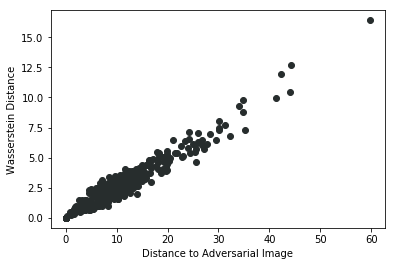

In [10]:
plt.scatter(dists_df['inf_to_adversary'], dists_df['wass_to_adversary'], color='#272d2d')
plt.xlabel('Distance to Adversarial Image')
plt.ylabel('Wasserstein Distance')
plt.savefig(os.path.join(save_loc, 'dist_to_adversary.png'), dpi=1000)

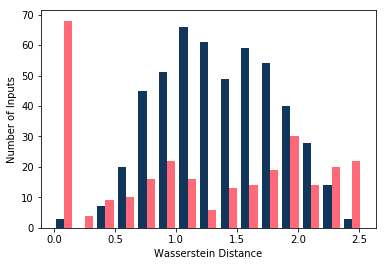

In [11]:
plt.hist([dists_df['wass_within_class'], dists_df['wass_to_adversary']], bins='auto', color=COLORS, label=PLT_LABELS)
plt.xlabel('Wasserstein Distance')
plt.ylabel('Number of Inputs')
plt.savefig(os.path.join(save_loc, 'dist_hist.png'), dpi=1000)